# Analyze results of  $\rm Cs Er Se_2$ "loopthrough" where we found the range of Hamiltonians within one standard deviation in $\chi^2$

Allen Scheie

December 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import sys

import plotformat as pf
import PyCrystalField as cef
from pythonlib.MsliceData import mslice



## Import all the data
datadirectory = 'CES_CEF_data/'

cutlist =   ['CES_100K_9meV',            'CES_2K_9meV',
            'CES_50K_9meV',            'CES_2K_9meV_3T',
            'CES_2K_9meV_5T',            'CES_2K_9meV_0T',
            'CES_2K_9meV_1T',            'CES_2K_9meV_2T',
            'CES_2K_9meV_0Tb',    'CES_2K_30meV']

ProtonCharges = [7.97, 8*3, 8*3+5.61, 8+6.59, 5.07, 2, 4,4,1.13, 8*4+5.1]  
# The proton charge doesn't seem to correct the normalization problem.
# Rather, the sample seems to have decreased in intensity post-5T field...
# See the cell below where I derive the scale factor.
scalefactor = 1.66582869
Norm = [scalefactor, 1,1, scalefactor, scalefactor, scalefactor, 
        scalefactor, scalefactor, scalefactor, scalefactor,]

DATA = {}
for i,cn in enumerate(cutlist):
    DATA[cn] = mslice(datadirectory+cn)
    DATA[cn].normalize(1e3*Norm[i])
    
    
## Define data

alldata = [DATA[cn] for cn in ['CES_2K_9meV', 'CES_50K_9meV']]
datatemps = [1.8, 50]

In [2]:
ll, ul = 160, 260
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0T'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleA, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0Tb'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleB, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
print((pscaleA+pscaleB)/2)

scalevalue = np.mean([pscaleA, pscaleB])

[1.]


<IPython.core.display.Javascript object>


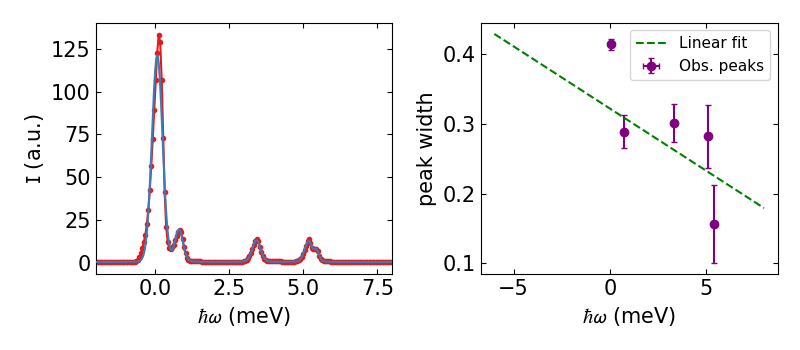

[0.07517211974600753, 0.7310563754703909, 3.3430389113350087, 5.0971456786049085, 5.377777212698675] [0.4132660062508849, 0.288638322840261, 0.3005368004446522, 0.2815966433551471, 0.1566254770893106] 0.050394384987051934
[-0.01778629  0.32154258]


In [3]:
## Pick out observed eigenvalues
from scipy.special import wofz

def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0].cx, alldata[0].ci, alldata[0].ce

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.45

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.45

p0 = [56, 0.15,0.27, 8,0.67,0.25, 5,3.27,0.25, 3,5.0,0.10, 2,5.25,0.10, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]

## Adjust the measured observed width so it matches the peak (not perfectly Gaussian...)
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
# ax[1].plot(xxx, resfunc(xxx), color='red', ls='--', label = "Ovi's res. func.")
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

<IPython.core.display.Javascript object>


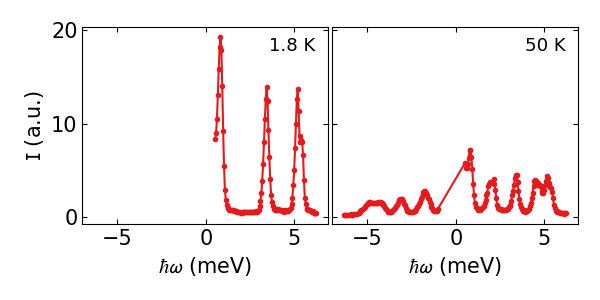

In [4]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i].cx = np.hstack((fitdata[i].cx[20:120], fitdata[i].cx[150:265]))
    fitdata[i].ci = np.hstack((fitdata[i].ci[20:120], fitdata[i].ci[150:265]))
    fitdata[i].ce = np.hstack((fitdata[i].ce[20:120], fitdata[i].ce[150:265]))
    
fitdata[0].cx = fitdata[0].cx[100:]
fitdata[0].ci = fitdata[0].ci[100:]
fitdata[0].ce = fitdata[0].ce[100:]
    
f, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)
pf.replace_zeros()

## Define global Chi2

In [5]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]

Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

Coefficients = np.array([-4.02401422e-02, -3.77639706e-04,  1.42541502e-02,  3.17197840e-06,
        2.22389952e-06,  3.80096353e-05])
Er = cef.CFLevels(Er_O, Coefficients)
Er.diagonalize()
        
######################

def bkg(iii, x):
    if iii == 0:
        return gaus(x, 2, 3.5, 2.5) + 0.2  + gaus(x, 7, 0.1, 0.25)
    else:
        return gaus(x, 6.5, 1.5, 5) + 0.1  + gaus(x, 7, 0.1, 0.25)



def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref, thermexp, bkgscale):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data.cx*(1+datatemps[i]*thermexp)-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                bkg(i, data.cx)*bkgscale[i] - data.ci
        erro += np.nansum((errspec/data.ce)**2)


    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

# Compare the different best fit coefficients

In [6]:
bestfitline = np.load('CES_loopthrough_bestfitline.npy',
                                          allow_pickle=True)

# Analyze output

In [8]:
for i in range(len(bestfitline[0])):
    bflcoeff = bestfitline[1:7, i]

    newH = np.sum([a*b for a,b in zip(Er.O, bflcoeff)], axis=0)
    Er.diagonalize_banded(newH)
    print(bestfitline[-1,i], '\t', Er.eigenvectors[0][7:9],'\t', Er.eigenvectors[1][7:9])

8.517274108579953 	 [-0.5153326  0.       ] 	 [0.        0.5153326]
8.815569484957592 	 [0.54523675 0.        ] 	 [0.         0.54523675]
9.701778102331026 	 [0.64396926 0.        ] 	 [ 0.         -0.64396926]
9.185272765850609 	 [0.6700321 0.       ] 	 [ 0.        -0.6700321]
8.99190933844369 	 [0.        0.6827583] 	 [0.6827583 0.       ]
9.087990145817527 	 [0.6699785 0.       ] 	 [ 0.        -0.6699785]
9.237516462271708 	 [ 0.         -0.65696332] 	 [0.65696332 0.        ]
9.570835215453432 	 [ 0.         -0.64397466] 	 [0.64397466 0.        ]
10.036929188704478 	 [0.63075934 0.        ] 	 [ 0.         -0.63075934]
8.815569484957532 	 [0.54523675 0.        ] 	 [0.         0.54523675]
8.618577824232906 	 [-0.53041298  0.        ] 	 [0.         0.53041298]
8.517274108579828 	 [-0.5153326  0.       ] 	 [0.        0.5153326]
8.58953526638518 	 [-0.50023168  0.        ] 	 [0.         0.50023168]
8.806578626985432 	 [-0.48501412  0.        ] 	 [0.         0.48501412]
9.16870042408362 	 

In [9]:
numfreeparams = len(np.hstack(([alldata[i].ci for i in range(len(alldata))])))

## Loop through best fit line and calculate chi2 for many points
for i in range(len(bestfitline[0])):
    print(err_global_final(Er, bestfitline[1:7, i],  gammas = bestfitline[7:9, i], 
                       xoff= bestfitline[9, i], pref=bestfitline[0, i], 
                        thermexp=bestfitline[10, i], bkgscale=[1,1])/ numfreeparams)

 err = 5110.364465147972    8.517274108579953
 err = 5289.341690974556    8.815569484957592
 err = 5821.066861398616    9.701778102331026
 err = 5511.1636595103655    9.185272765850609
 err = 5395.145603066214    8.99190933844369
 err = 5452.794087490516    9.087990145817527
 err = 5542.509877363025    9.237516462271708
 err = 5742.501129272059    9.570835215453432
 err = 6022.157513222687    10.036929188704478
 err = 5289.341690974519    8.815569484957532
 err = 5171.146694539743    8.618577824232906
 err = 5110.364465147897    8.517274108579828
 err = 5153.721159831108    8.58953526638518
 err = 5283.947176191259    8.806578626985432
 err = 5501.2202544501715    9.16870042408362
 err = 5805.739296589748    9.676232160982913


In [11]:
import scipy.linalg as LA
import scipy.sparse.linalg as SLA


def curvedline(x,a,b, c):
    return a*x + b + c*x**2

ll = 11
popt, pcov = [], []
indices = [0,1,2,3,4,5,6,7,8,9,10,11]
for i in indices:
    popt0, pcov0 = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[i][ll:])
    popt.append(popt0)
    pcov.append(pcov0)


def bestfitCoeff(B20):
    bfc = []
    for i in range(11):
        bfc.append( curvedline(B20, *popt[i]))
    return bfc

    
from time import time
starttime = time()
    
B20array = np.linspace(-0.042198, -0.02945, 100)
# B20array = np.linspace(-0.04, -0.039, 20)
B20array_chi2 = []
j0p5weights = []
for i, B20 in enumerate(B20array):
    cf = bestfitCoeff(B20)
    B20array_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:9], 
                       xoff= cf[9], pref=cf[0], 
                        thermexp=cf[10], bkgscale=[1,1])/ numfreeparams)
    
    newH = np.sum([a*b for a,b in zip(Er.O, cf[1:7])], axis=0)
    Er.diagonalize_banded(newH)
    j0p5weights.append(np.max(np.abs(Er.eigenvectors[0][7:9])))
    
print('time =',time()-starttime)

print('mean J=1/2:', np.mean(j0p5weights), 'pm', (np.max(j0p5weights)-np.min(j0p5weights))/2)

 err = 5712.350795085638     time = 1.534315586090088
mean J=1/2: 0.5131719904763657 pm 0.05426978300191207


<IPython.core.display.Javascript object>


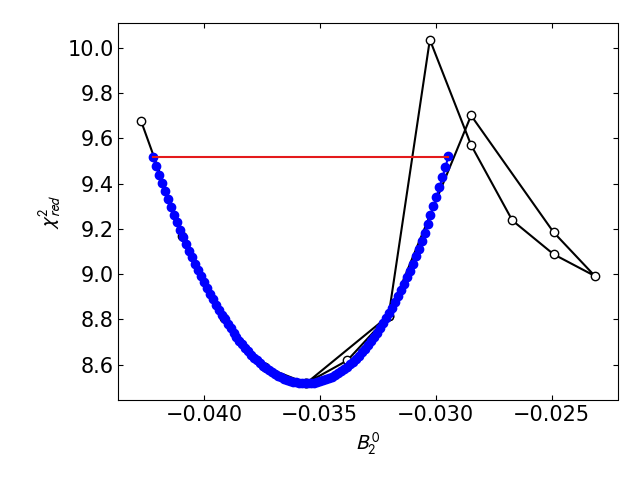

In [12]:
chisqstyle = {'marker':'o'}

plt.figure()
plt.plot(bestfitline[1], bestfitline[-1], color='k', marker='o', mfc='w')
plt.plot(B20array, B20array_chi2, color='b',  **chisqstyle)
plt.plot(B20array[np.array([0,-1])], [np.min(B20array_chi2)+1,np.min(B20array_chi2)+1])
plt.ylabel('$\\chi^2_{red}$')
#ax2.set_ylim(0,)
plt.xlabel('$B_2^0$')
plt.tight_layout()

In [14]:
## Import magnetization
CESMHdata = np.genfromtxt('CsErSe2_bulkdata/CsErSe2_MHall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

Na = 6.02214076e23 
SCF = 1/(1.07828221e24/Na)
# import susceptibility
RawMTdata = np.genfromtxt('CsErSe2_bulkdata/CsErSe2_MTall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)
## Take some averages because it is TOO many data points
CESMTdata = []
for i in range(len(RawMTdata)):
    CESMTdata.append(np.mean(RawMTdata[i].reshape(-1,5), axis=1))


Mtemp = 2
fieldstrengths = np.arange(0,7.1,0.1)
magnetization = np.zeros((len(fieldstrengths), 3, 3))
netmag = np.zeros(len(fieldstrengths))

########################################


model1color= pf.adjustlightness(pf.cpal1[2], 0.3)#'k'
model2color= pf.adjustlightness(pf.cpal1[0], 0.3)
KEScolor = pf.cpal1[1] # pf.adjustlightness(pf.cpal1[1], 0.5)
CEScolor = np.array([0,0,0,1]) #pf.adjustlightness(pf.cpal1[3], 0.1, False)
# dataprops = {'ls':'-','marker':'o', 'ms':4, 'mew':1,'color':'k', 'label':'data'}
KESdataprops = {'ls':'-','marker':'.','color':KEScolor, 'label':'data'}
CESdataprops = {'ls':'-','marker':'.','color':CEScolor, 'label':'data'}


CESab_data = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor, 0.5, False), 'markersize':4}
CESc_data = {'marker':'s', 'ls':'none', 'color':CEScolor, 'markersize':4}
CESpow_data = {'marker':'s', 'ls':'none','color':CEScolor, 'markersize':4}


KESab_dataM = {'marker':'o', 'ls':'none', 'mfc':'w', 'mec':  pf.adjustlightness(KEScolor, 0.8)}
KESc_dataM = {'marker':'o', 'ls':'none', 'color':KEScolor, 'mec':pf.adjustlightness(KEScolor, 0.8)}

CESab_dataM = {'marker':'s', 'ls':'none', 'mfc':'w', 'mec':pf.adjustlightness(CEScolor, 0.5)}
CESc_dataM = {'marker':'s', 'ls':'none', 'color':pf.adjustlightness(CEScolor,0.2,False), 
          'mec':pf.adjustlightness(CEScolor, 0.5)}


<IPython.core.display.Javascript object>


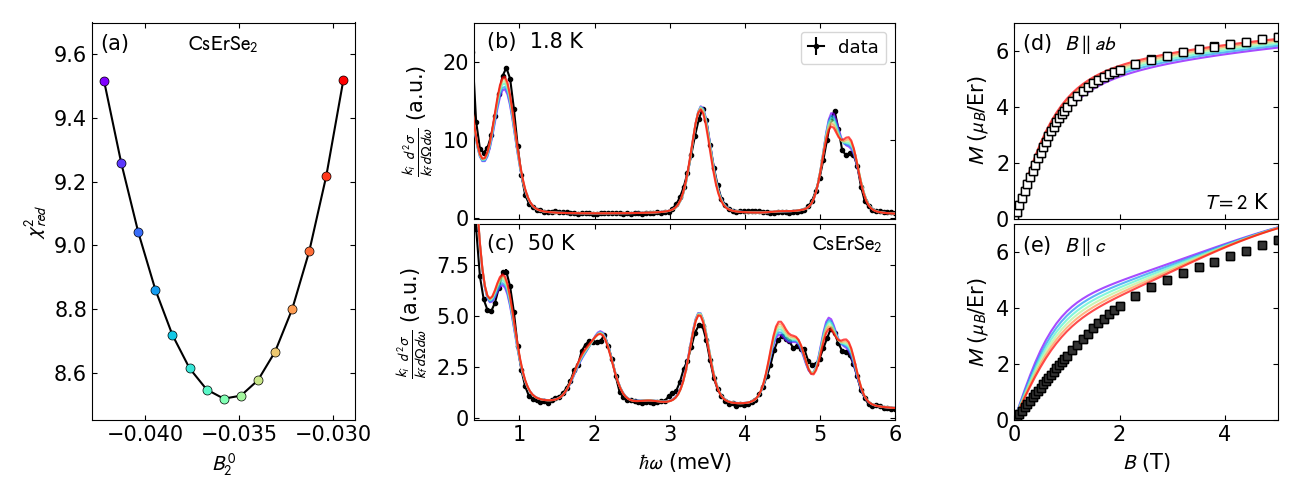

 err = 5712.350795085638     

In [15]:

#######################################################################

fig2 = plt.figure(figsize=(13,5))
outer = gridspec.GridSpec(1,3, figure=fig2, width_ratios=[1,1.6,1])
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], hspace=0.03)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2], hspace=0.03)

ax0 = fig2.add_subplot(outer[0])
ax = [fig2.add_subplot(gs0[i]) for i in range(2)]
ax2 = [fig2.add_subplot(gs1[i]) for i in range(2)]
# ax3 = fig2.add_subplot(outer[3])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax2[0].get_xticklabels(), visible=False)

xxx = np.linspace(-10,30,1200)

B20values = np.linspace(np.min(B20array), np.max(B20array), 6)
# B20colors = plt.cm.bwr(np.linspace(0,1,len(B20values)))
B20colors = plt.cm.rainbow(np.linspace(0,1,len(B20values)))

sf=1e3


plotted_chi2 = []
    
#     for j,Bopt in enumerate(bestfitline.T):
for j,B20 in enumerate(B20values):
    cf = bestfitCoeff(B20)
    Er = cef.CFLevels(Er_O, cf[1:7])
    Er.diagonalize()

#     plotted_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:9], 
#                        xoff= cf[9], pref=cf[0], 
#                         thermexp=cf[10], bkgscale=[1,1])/ numfreeparams)
    
    for i,data in enumerate(alldata):
        if j == 0 :
            ax[i].errorbar(data.cx, data.ci, data.ce,  **CESdataprops)

        
        ax[i].plot(xxx, (bestfitline[0][j]*Er.normalizedNeutronSpectrum(
                        Earray=xxx*(1+datatemps[i]*cf[10]) - cf[9], 
                            Temp=datatemps[i], ResFunc=lambda de: straightline(de,*width_popt),  
                                    gamma=cf[7:9][i]) + bkg(i, xxx)), 
                            zorder=10, color=B20colors[j], alpha=0.7)

    ## compute and plot magnetizaiton
    for ii, fs in enumerate(fieldstrengths):
        magnetization[ii,0] = Er.magnetization(ion, Mtemp, [fs,0,0])
        magnetization[ii,1] = Er.magnetization(ion, Mtemp, [0,fs,0])
        magnetization[ii,2] = Er.magnetization(ion, Mtemp, [0,0,fs])

    ax2[0].plot(fieldstrengths, -magnetization[:,0,0], color=B20colors[j], alpha=0.7)
    ax2[1].plot(fieldstrengths, -magnetization[:,2,2], color=B20colors[j], alpha=0.7)


################
# Plot chi2

B20values2 = np.linspace(np.min(B20array), np.max(B20array), 15)
B20colors2 = plt.cm.rainbow(np.linspace(0,1,len(B20values2)))

for j,B20 in enumerate(B20values2):
    cf = bestfitCoeff(B20)
    Er = cef.CFLevels(Er_O, cf[1:7])
    Er.diagonalize()

    plotted_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:9], 
                       xoff= cf[9], pref=cf[0], 
                        thermexp=cf[10], bkgscale=[1,1])/ numfreeparams)
    ax0.plot(B20, plotted_chi2[j], marker='o', ms=5, color=B20colors2[j])
ax0.plot(B20values2, plotted_chi2, marker='o',color='k',mfc='none', zorder=-1)
ax0.set_ylabel('$\\chi^2_{red}$')
#ax2.set_ylim(0,)
ax0.set_xlabel('$B_2^0$')
ax0.text(0.03,0.97, '(a)', transform=ax0.transAxes,
              verticalalignment='top', horizontalalignment='left')
ax0.text(0.5,0.97, '$\\rm CsErSe_2$', transform=ax0.transAxes,
              verticalalignment='top', horizontalalignment='center')
ax0.set_ylim(8.45,9.7)

################

        
for i in range(len(ax)):
#     ax[i].set_xlim(-6,8)
    ax[i].set_xlim(0.4,6)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
    ax[i].set_ylabel('$\\frac{k_i}{k_f} \\frac{d^2 \sigma}{d \\Omega d \\omega}$ (a.u.)')



ax[0].set_ylim(-0.1,25)
ax[1].set_ylim(-0.1,9.5)
# ax[2].set_ylim(-0.1,8)
ax[0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)

subplotlabels = 'abcdefghijk'
ax2labels = ['$B \\parallel ab$', '$B \\parallel c$']
for i, axx in enumerate(ax):
    axx.text(0.03,0.95, '('+subplotlabels[i+1]+')  '+str(datatemps[i])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    
    ax2[i].text(0.03,0.95, '('+subplotlabels[i+3]+')  '+ax2labels[i], transform=ax2[i].transAxes,
              verticalalignment='top', horizontalalignment='left')


ax[-1].text(0.97,0.95, '$\\rm CsErSe_2$', transform=ax[-1].transAxes,
              verticalalignment='top', horizontalalignment='right')



############################# Plot magnetization

ax2[0].plot(CESMHdata[0]/1e4,CESMHdata[1],label='data ($H \\parallel ab$)', **CESab_dataM)
ax2[1].plot(CESMHdata[6]/1e4,CESMHdata[7],label='data ($H \\parallel c$)', **CESc_dataM)

ax2[-1].set_xlabel('$B$ (T)')
for i in range(2):
    ax2[i].set_ylabel('$M$ ($\mu_B$/Er)')
    ax2[i].set_xlim(0,5)
    ax2[i].set_ylim(0,7)

# ax2[0].text(1.2,6.1,'$H \\parallel ab$')
# ax2[1].text(1.2,6.1,'$H \\parallel c$')
ax2[0].text(0.97,0.03,'$T=2$ K', transform=ax2[0].transAxes, verticalalignment='bottom',
           horizontalalignment='right')
    
plt.tight_layout()

pf.replace_zeros()

# Get uncertanties of CEF eigenvalues and eigenvectors

In [28]:
def curvedline(x,a,b, c):
    return a + b*x + c*x**2

ll = 11
popt, pcov = [], []
indices = [0,1,2,3,4,5,6,7,8,9,10,11]
for i in indices:
    popt0, pcov0 = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[i][ll:])
    popt.append(popt0)
    pcov.append(pcov0)

    
labels = ['scale factor','$B_2^0$','$B_4^0$','$B_4^3$','$B_6^0$','$B_6^3$','$B_6^6$',
         '$LW_{\\rm 1.8\\>K}$', '$LW_{\\rm 50\\>K}$', '$\hbar \omega$ offset', 
          'therm, expan.', '$\\chi^2$']


print('\\begin{table}\n\\caption{Best fit curve through parameter space for $\\rm CsErSe_2$,'+\
      ' where variable$=a + b (B_2^0) + b (B_2^0)^2 $}')
print('\\begin{ruledtabular}')
numpar = 3
print('\\begin{tabular}{c|'+'c'*numpar+'}')
print('Variable & a & b & c  \\tabularnewline\n \\hline ')

for i in range(len(bestfitline)-1):
    punci =  np.sqrt(np.diag(pcov[i]))
    strpopt = []
    for j in range(3):
        fnz = -(int(np.log10(punci[j]))-1) # first non-zero in uncertainty
        if fnz > 0:
            newstring = str(np.around(popt[i][j], fnz))+'('+str(np.around(punci[j],fnz))[-1]+')'
            if 'e' in newstring:
                splitstring = newstring.split('e-0')
                newstring = splitstring[0]+splitstring[1][-3:] + '$\\times 10^{-' +splitstring[1][:-3]+ '}$'
                strpopt.append(newstring)
            else:
                strpopt.append(newstring)
        else:
            fnz = -int(np.log10(punci[j]))
            strpopt.append(str(int(np.around(popt[i][j], fnz)))+'('+str(int(np.around(punci[j],fnz)))+')')
    if i != 1:
        print(labels[i],' &\t', ' & \t'.join(strpopt), ' \\tabularnewline')
        
print('\\end{tabular}\\end{ruledtabular}')
print('\\label{flo:CES_bestfitline}\n\\end{table}')

\begin{table}
\caption{Best fit curve through parameter space for $\rm CsErSe_2$, where variable$=a + b (B_2^0) + b (B_2^0)^2 $}
\begin{ruledtabular}
\begin{tabular}{c|ccc}
Variable & a & b & c  \tabularnewline
 \hline 
scale factor  &	 0.435(6) & 	0.5(3) & 	11.6(1)  \tabularnewline
$B_4^0$  &	 -0.0004337(7) & 	-0.00103(5) & 	0.0095(2)  \tabularnewline
$B_4^3$  &	 -0.0112(5) & 	0.111(1) & 	0.95(2)  \tabularnewline
$B_6^0$  &	 2.952(9)$\times 10^{-6}$ & 	-4.9(7)$\times 10^{-6}$ & 	2.2(6)$\times 10^{-5}$  \tabularnewline
$B_6^3$  &	 -2.77(7)$\times 10^{-5}$ & 	-0.000753(6) & 	-0.00297(5)  \tabularnewline
$B_6^6$  &	 8.6(7)$\times 10^{-6}$ & 	-0.00086(5) & 	-0.0043(1)  \tabularnewline
$LW_{\rm 1.8\>K}$  &	 0.072(9) & 	0.9(4) & 	15.4(6)  \tabularnewline
$LW_{\rm 50\>K}$  &	 0.087(2) & 	1.3(1) & 	24.1(6)  \tabularnewline
$\hbar \omega$ offset  &	 0.148(1) & 	0.54(6) & 	-1.0(7)  \tabularnewline
therm, expan.  &	 0.0(5) & 	-0.003(2) & 	0.01(3)  \tabularnewline
\end{tabular}\end{ruledtabular}


Now we must order the terms in the eigenvectors so that we can properly take the average. Unfortunately, the Scipy Linear Algebra package doesn't give the degenerate doublets in the same order when the Hamiltonian is slightly modified. So this must be done by hand.

In [46]:
def bestfitCoeff(B20):
    bfc = []
    for i in range(11):
        bfc.append( curvedline(B20, *popt[i]))
    return bfc
            
def findbands(matrix):
    diag = np.diag(matrix)
    band1 = [matrix[i,i+3] for i in range(len(matrix)-3)] + [0]*3
    band2 = [matrix[i,i+6] for i in range(len(matrix)-6)] + [0]*6
    return np.array([diag,[0]*len(matrix),[0]*len(matrix), band1,[0]*len(matrix),[0]*len(matrix), band2])
    
    
    
B20array = np.linspace(-0.042198, -0.02945, 3)
BestFitBvalues = []
B20array_chi2 = []
j0p5weights = []
RangeEvals = []
RangeEvecs = []
for i, B20 in enumerate(B20array):
    cf = bestfitCoeff(B20)
    BestFitBvalues.append(cf[1:7])
    B20array_chi2.append(err_global_final(Er, cf[1:7],  gammas = cf[7:9], 
                       xoff= cf[9], pref=cf[0], 
                        thermexp=cf[10], bkgscale=[1,1])/ numfreeparams)
    
    newH = np.sum([a*b for a,b in zip(Er.O, cf[1:7])], axis=0)
#     print(newH)
    bands = findbands(newH)
    diagonalH = LA.eig_banded(bands, lower=True)
    eigenvectors = diagonalH[1].T
#     print('\n', eigenvectors[0],'\n', eigenvectors[1],'\n')
#     print('\n', np.around(eigenvectors[14],10),'\n', np.around(eigenvectors[15],10),'\n')
    RangeEvals.append(diagonalH[0] - np.min(diagonalH[0]))
    if i == 0:
        RangeEvecs.append([eigenvectors[0], eigenvectors[1],
                            -eigenvectors[3],-eigenvectors[2],
                           eigenvectors[4], eigenvectors[5],
                           eigenvectors[6], eigenvectors[7],
                          -eigenvectors[9], eigenvectors[8],
                          eigenvectors[11], eigenvectors[10],
                          eigenvectors[12], eigenvectors[13],
                          eigenvectors[15], eigenvectors[14]])
    elif i == 1:
        RangeEvecs.append(eigenvectors)
    elif i == 2:
        RangeEvecs.append([-eigenvectors[0],eigenvectors[1],
                            -eigenvectors[3],-eigenvectors[2],
                           eigenvectors[4], eigenvectors[5],
                          eigenvectors[7], -eigenvectors[6],
                          eigenvectors[8], eigenvectors[9],
                           eigenvectors[10], -eigenvectors[11],
                          -eigenvectors[12], eigenvectors[13],
                          eigenvectors[15], eigenvectors[14]])
        

RangeEvecs = np.array(RangeEvecs)
RangeEvals = np.array(RangeEvals)

# print('mean J=1/2:', np.mean(j0p5weights), 'pm', (np.max(j0p5weights)-np.min(j0p5weights))/2)

 err = 5712.350795085638    

In [47]:
def stringify_uncertainty(value, uncertainty):
    try:
        fnz = -(int(np.log10(uncertainty))-1) # first non-zero in uncertainty
        if fnz > 0:
            newstring = str(np.around(value, fnz))+'('+str(np.around(uncertainty,fnz))[-1]+')'
            if 'e' in newstring:
                splitstring = newstring.split('e-')
                newstring = splitstring[0]+splitstring[1][-3:] + '$\\times 10^{-' +splitstring[1][:-3]+ '}$'
        else:
            newstring = str(np.around(value, fnz))+'('+str(np.around(uncertainty,fnz))[0]+')'
        return newstring
    except OverflowError:
        return str(np.around(value,1))

    
    
'''for every eigenvalue, print the nonzero weights'''
print('\n')


print('\\begin{table*}\n\\caption{Eigenvectors and Eigenvalues for $\\rm CsErSe_2$}')
print('\\begin{ruledtabular}')
numwt = 6
print('\\begin{tabular}{c|'+'r'*numwt+'}')
print('Eigenvalues (meV) & '+'& '*(numwt-1) + 'Eigenvectors' +' \\tabularnewline\n \\hline ')

nmatrix = 15
kk = np.arange(-nmatrix, nmatrix+1, 2)
for i in range(nmatrix+1):
    EVvalue = stringify_uncertainty(np.around(RangeEvals[1][i],10), 
                                    np.abs(RangeEvals[1][i]-RangeEvals[0][i]))

    
    EV_nonzero_list = []
    for j in range(nmatrix+1):
        # Find fractional value
        if kk[j] < 0:
            frac = '| - \\frac{'+str(abs(kk[j]))+'}{2}\\rangle $'
        else:
            frac = '| \\frac{'+str(abs(kk[j]))+'}{2}\\rangle $'
        
        #print(RangeEvecs[0][i])
        if RangeEvecs[1][i][j] == 0:
            pass
        else:
            EVvector = stringify_uncertainty(np.around(RangeEvecs[1][i][j],10), 
                                    np.abs(RangeEvecs[1][i][j]-RangeEvecs[0][i][j]))
            if EVvector.startswith('-'):
                EV_nonzero_list.append(EVvector +'~ '+ frac)
            elif EV_nonzero_list==[]:
                EV_nonzero_list.append(EVvector +'~ '+ frac)
            else:
                EV_nonzero_list.append('+'+EVvector +'~ '+ frac)
     
#     print(len(EV_nonzero_list))
    print(EVvalue, ' & & $', ' & $'.join(EV_nonzero_list), ' \\tabularnewline')
    
print('\\end{tabular}\\end{ruledtabular}')
print('\\label{flo:CES_Eigenvectors}\n\\end{table*}')



\begin{table*}
\caption{Eigenvectors and Eigenvalues for $\rm CsErSe_2$}
\begin{ruledtabular}
\begin{tabular}{c|rrrrrr}
Eigenvalues (meV) & & & & & & Eigenvectors \tabularnewline
 \hline 
0.0  & & $ -0.59(4)~ | - \frac{13}{2}\rangle $ & $+0.513(3)~ | - \frac{7}{2}\rangle $ & $-0.51(5)~ | - \frac{1}{2}\rangle $ & $-0.338(2)~ | \frac{5}{2}\rangle $ & $-0.123(9)~ | \frac{11}{2}\rangle $  \tabularnewline
0.0(5)  & & $ 0.123(9)~ | - \frac{11}{2}\rangle $ & $-0.338(2)~ | - \frac{5}{2}\rangle $ & $+0.51(5)~ | \frac{1}{2}\rangle $ & $+0.513(3)~ | \frac{7}{2}\rangle $ & $+0.59(4)~ | \frac{13}{2}\rangle $  \tabularnewline
0.675(5)  & & $ 0.78(2)~ | - \frac{15}{2}\rangle $ & $-0.46(1)~ | - \frac{9}{2}\rangle $ & $+0.36(3)~ | - \frac{3}{2}\rangle $ & $+0.224(5)~ | \frac{3}{2}\rangle $ & $+0.032(7)~ | \frac{9}{2}\rangle $ & $-0.004(4)~ | \frac{15}{2}\rangle $  \tabularnewline
0.675(5)  & & $ 0.004(4)~ | - \frac{15}{2}\rangle $ & $+0.032(7)~ | - \frac{9}{2}\rangle $ & $-0.224(5)~ | - \frac{3}{2}\r

# Print out G tensor

In [48]:
def calculateErGTensor(coeff):
    KES = cef.CFLevels(Er_O, coeff)
    gg = KES.gtensor()
    print(gg)
    return [gg[0,0], gg[2,2]]


avgG = []
for i in range(len(BestFitBvalues)):
    avgG.append(calculateErGTensor(BestFitBvalues[i]))
    
avgG = np.abs(np.array(avgG).T)

print('\n g_xy = ', stringify_uncertainty(np.mean(avgG[0]), np.abs(avgG[0][0]-avgG[0][2])/2),
     '\n g_zz = ', stringify_uncertainty(np.mean(avgG[1]), np.abs(avgG[1][0]-avgG[1][2])/2))

# print(calculateErGTensor(FitCoefRes1['coeff']))

[[-5.1571017   0.          0.        ]
 [ 0.         -5.1571017   0.        ]
 [ 0.          0.          6.38103543]]
[[-5.44424906  0.          0.        ]
 [ 0.         -5.44424906  0.        ]
 [ 0.          0.          5.8397826 ]]
[[5.694497   0.         0.        ]
 [0.         5.694497   0.        ]
 [0.         0.         5.35694006]]

 g_xy =  5.4(3) 
 g_zz =  5.9(5)


In [49]:
print('[')
for i in range(6):
    strigified = stringify_uncertainty(BestFitBvalues[1][i], 
                                       np.abs(BestFitBvalues[2][i]-BestFitBvalues[1][i]))
    print('"'+strigified+'",')
print(']')

[
"-0.036(6)",
"-0.00038(5)",
"-0.0139(3)",
"3.16(8)$\times 10^{-06}$",
"-5(6)$\times 10^{-06}$",
"3.4(6)$\times 10^{-05}$",
]


In [50]:
FitCoefRes1, FitCoefRes2 = np.load('CES_bestfitcoeff.npy',allow_pickle=True)

print('[')
for i in range(6):
    print([FitCoefRes1['coeff'][i], np.abs(BestFitBvalues[2][i]-BestFitBvalues[1][i])],',')
print(']')

[
[-0.03558826477406324, 0.006374001208210786] ,
[-0.00038490955035355495, 1.0547888144487661e-05] ,
[-0.013934150762939518, 0.0003105000763916031] ,
[3.153756556717663e-06, 4.019272424875444e-08] ,
[-4.694996912445858e-06, 3.5638144873689042e-06] ,
[3.381152681327556e-05, 3.6928861055783826e-06] ,
]
